In [28]:
from neo4j import GraphDatabase
import pandas as pd
from openai import OpenAI
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
import json
from collections import Counter
import os
from itertools import combinations
from dowhy import CausalModel
import re
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import warnings
from typing import Optional, List, Tuple, Dict
import numpy as np
from dataclasses import dataclass
from sklearn.preprocessing import MinMaxScaler

load_dotenv()

# NumPy関連のRuntimeWarningを無効化
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [29]:
# DB接続処理
# Neo4jに接続
uri = "bolt://localhost:7687"
user = "neo4j"
password = "abcd7890"

# ドライバを作成
driver = GraphDatabase.driver(uri, auth=(user, password))

## similarityのスコア化検証

In [30]:
@dataclass
class SimilarityResult:
    WD_similar: Dict[Tuple[str, str], float]  # Similarity vector for WD (can be an empty dictionary or None)
    FV_similar: Dict[Tuple[str, str], float] # Similarity vector for FV (can be an empty dictionary or None)
    WD_similar_AVG: float       # Average similarity for WD (default to 0 if None)
    FV_similar_AVG: float       # Average similarity for FV (default to 0 if None)
    compound_counts: Dict[Tuple[str, str], float]   # Molecule count (can be an empty dictionary or None)
    compound_AVG: float         # Average number of molecules (default to 0 if None)
    aroma_counts: Dict[Tuple[str, str], float]      # Aroma count (can be an empty dictionary or None)
    aroma_AVG: float
    food_count: int                  # The count of ingredients in the row

In [31]:
def find_food(tx, search_term):
    find_food_query = """
    CALL db.index.fulltext.queryNodes("food_origin_index_text_search", $search_term)
    YIELD node, score as full_text_score
    ORDER BY full_text_score DESC, size(node.name)
    LIMIT 1
    RETURN node.id as node_id, node.name as node_name, node.flavor_vector as flavor_vector, node.word_vector as word_vector, full_text_score    
    """
    result = tx.run(find_food_query, search_term=search_term).data()
    if result:
        return result[0]
        
    return None

In [32]:
def find_compound_count(id1, id2):
    with driver.session() as session:
        find_aroma_query = """
        // Step 1: 特定のFoodノードから関連するCompoundを取得
        MATCH (f1:Food {id: $id1})-[:HAS_SUBTYPE]->(fst1:FoodSubType)-[:CONTAINS]->(comp:Compound)
        
        // Step 2: CompoundのIDをリストとして取得
        WITH COLLECT(comp.id) AS compoundIds

        // Step 3: 同じCompoundを共有するFoodノードを取得
        MATCH (f2:Food {id: $id2})-[:HAS_SUBTYPE]->(fst2:FoodSubType)-[:CONTAINS]->(comp2:Compound)
        WHERE comp2.id IN compoundIds
        
        RETURN count(comp2.id) AS c
        """
        aroma_result = session.run(find_aroma_query, id1=id1, id2=id2).data()
        return aroma_result[0]["c"] if aroma_result else 0
    
    
def find_aroma_count(id1, id2):
    with driver.session() as session:
        find_aroma_query = """
        // Step 1: 特定のFoodノードから関連するCompoundを取得
        MATCH (f:Food {id: $id1})-[:HAS_SUBTYPE]->(fs:FoodSubType)-[:SCENTED]->(aroma1:Aroma)
        
        // Step 2: CompoundのIDをリストとして取得
        WITH COLLECT(aroma1.id) AS aromaIds

        // Step 3: 同じCompoundを共有するFoodノードを取得
        MATCH (f2:Food {id: $id2})-[:HAS_SUBTYPE]->(fst2:FoodSubType)-[:SCENTED]->(aroma2:Aroma)
        WHERE aroma2.id IN aromaIds
        
        RETURN count(aroma2.id) AS c
        """
        aroma_result = session.run(find_aroma_query, id1=id1, id2=id2).data()
        return aroma_result[0]["c"] if aroma_result else 0

In [33]:
def get_food_list(dish):
    with driver.session() as session:
        ar_result = []
        for target in dish:
            target = target.lower()
            result1 = session.execute_read(find_food, target)
            if result1 is None:
                print(f"No record found: {target}")
                continue
            if result1['flavor_vector'] is None:
                print(f"No flavor vector: {target}")
                continue
            
            ar_result.append(result1)
        
        pd_result = pd.DataFrame(ar_result, columns=['node_id', 'node_name', 'flavor_vector', 'word_vector', 'full_text_score'])
        
        return pd_result

In [34]:
def get_similarity(id1, id2):
    with driver.session() as session:
        # Step 1: Find the similarity between the two ingredients
        find_similarity_query = """
            // Step 1: 特定のFoodノードから関連するCompoundを取得
            MATCH (f1:Food {id: $id1})-[:HAS_SUBTYPE]->(fst1:FoodSubType)-[:CONTAINS]->(comp:Compound)

            // Step 2: CompoundのIDをリストとして取得
            WITH f1, f1.flavor_vector AS f1Vector, COLLECT(comp.id) AS compoundIds

            // Step 3: 同じCompoundを共有するFoodノードを取得
            MATCH (f2:Food {id: $id2})-[:HAS_SUBTYPE]->(fst2:FoodSubType)-[:CONTAINS]->(comp2:Compound)
            WHERE comp2.id IN compoundIds

            // Step 4: ベクター計算
            WITH f2 AS f,
                COLLECT(DISTINCT fst2.key_note) AS key_notes,
                COUNT(DISTINCT comp2.id) AS count,
                AVG(gds.similarity.cosine(f1.word_vector, f2.word_vector)) AS word_score_avg,
                AVG(gds.similarity.overlap(f1.flavor_vector, f2.flavor_vector)) AS flavor_score_avg
                
            // Step 5: ユニークな結果を返す
            RETURN coalesce(word_score_avg, 0) as word_score_avg, coalesce(flavor_score_avg, 0) as flavor_score_avg
            ORDER BY word_score_avg DESC, flavor_score_avg DESC, count DESC;
         """
        similarity_result = session.run(find_similarity_query, id1=id1, id2=id2).data()
        if len(similarity_result) == 0:
            return {'word_score_avg': 0, 'flavor_score_avg': 0}
        
        return similarity_result[0]

In [35]:
def get_similarities(dish):
    # 食材の一覧を取得
    pd_result = get_food_list(dish)

    # 材料のペアを生成    
    pairs = list(combinations(list(pd_result["node_id"]), 2))

    # 類似度を計算
    fv_cosine_similarities = []
    wv_cosine_similarities = []
    compound_counts = []
    aroma_counts = []
    for pair in pairs:
        ing1, ing2 = pair                 
        # コサイン類似度
        sim_result = get_similarity(ing1, ing2)
        fv_cosine_similarities.append(sim_result["word_score_avg"])
        wv_cosine_similarities.append(sim_result["flavor_score_avg"])
        compound_counts.append(find_compound_count(ing1, ing2))
        aroma_counts.append(find_aroma_count(ing1, ing2))

    # 各類似度の平均を計算
    fv_cosine_similarity_score = np.mean(fv_cosine_similarities)
    wv_cosine_similarities_score = np.mean(wv_cosine_similarities)
    compound_count_score = np.mean(compound_counts)
    aroma_count_score = np.mean(aroma_counts)

    return SimilarityResult(
        WD_similar=dict(zip(pairs, wv_cosine_similarities)),
        FV_similar=dict(zip(pairs, fv_cosine_similarities)),
        WD_similar_AVG=wv_cosine_similarities_score,
        FV_similar_AVG=fv_cosine_similarity_score,
        compound_counts=dict(zip(pairs, compound_counts)),
        compound_AVG=compound_count_score,
        aroma_counts=dict(zip(pairs, aroma_counts)),
        aroma_AVG= aroma_count_score,
        food_count=len(dish)
    )

In [36]:
excludes = ["potassium chloride", "grit", "ring", "spoon", "knife", "thermometer", "carb", "shirataki", "soil",
            "potassium", "chloride", "grit", "frying", "coloring", "dan", "lipase", "boil", "casserole", "culture",
            "carbs", "bear", "smoke", "psyllium husk", "starter", "rennet", "bed", "fire", "chutney", "authentic pad thai",
            "punch", "trader joe's", "cornstarch", "spray", "oven", "thai", "creme brulee", "pesto", "tablet", "bacteria", 
            "collagen", "soufflé", "sponge", "hay", "smoke flavoring", "boston", "strainer", "sieve", "panettone mold", "toothpicks"]

In [37]:
new_json_data = {}
with open("../data/formatted_json_recipe.json", "r") as file:
    new_json_data = json.load(file)
print(len(new_json_data))

1322


In [38]:
new_rows = []
counter = 0
result_wd_similarities = []
result_fv_similarities = []
for key, row in new_json_data.items():
    #counter += 1
    #if counter > 10:
    #    break
    
    if row["ingredients"] == []:
        continue
    
    if len(row["ingredients"]) < 3:
        continue
    
    ingredients = [ingredient for ingredient in row["ingredients"] if ingredient.strip().lower() not in excludes]
    similarity_result:SimilarityResult = get_similarities(ingredients)
    similarity_series = pd.Series(similarity_result.__dict__)
    similarity_series["name"] = key
    similarity_series["ingredients"] = ingredients
    
    for wd_pair, wd_score in similarity_series["WD_similar"].items():
        result_wd_similarities.append([wd_pair[0], wd_pair[1], wd_score])

    for fv_pair, fv_score in similarity_series["FV_similar"].items():
        result_fv_similarities.append([fv_pair[0], fv_pair[1], fv_score])

    if any(row.values()):
        new_rows.append(similarity_series)
        # break for debugging
    
    

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: '\n            // Step 1: 特定のFoodノードから関連するCompoundを取得\n            MATCH (f1:Food {id: $id1})-[:HAS_SUBTYPE]->(fst1:FoodSubType)-[:CONTAINS]->(comp:Compound)\n\n            // Step 2: CompoundのIDをリストとして取得\n            WITH f1, f1.flavor_vector AS f1Vector, COLLECT(comp.id) AS compoundIds\n\n            // Step 3: 同じCompoundを共有するFoodノードを取得\n            MATCH (f2:Food {id: $id2})-[:HAS_SUBTYPE]->(fst2:FoodSubType)-[:CONTAINS]->(comp2:Compound)\n            WHERE comp2.id IN compoundIds\n\n            // Step 4: ベクター計算\n            WITH f2 AS f,\n                COLLECT(DISTINCT fst2.key_note) AS key_notes,\n                COUNT(DISTINCT comp2.id) AS count,\n                AVG(gds.simi

No record found: matzo
No record found: matzo
No record found: brûle
No record found: crã¨me fraãiche


In [39]:
# 組み合わせごとの類似度を保存
df_wd_result = pd.DataFrame(result_wd_similarities, columns=["id1", "id2", "score"])
# MinMaxScaler に正しいデータ形式を渡す
df_wd_result["score"] = MinMaxScaler().fit_transform(df_wd_result["score"].values.reshape(-1, 1))
df_wd_result.to_csv("../data/analized_wd_combination.csv", index=False)

df_fv_result = pd.DataFrame(result_fv_similarities, columns=["id1", "id2", "score"])
df_fv_result["score"] = MinMaxScaler().fit_transform(df_fv_result["score"].values.reshape(-1, 1))
df_fv_result.to_csv("../data/analized_fv_combination.csv", index=False)

In [40]:
df_result = pd.DataFrame(new_rows)
df_result["WD_similar_AVG"] = df_result["WD_similar_AVG"].fillna(0)
df_result["FV_similar_AVG"] = df_result["FV_similar_AVG"].fillna(0)
df_result["compound_AVG"] = df_result["compound_AVG"].fillna(0)
df_result["aroma_AVG"] = df_result["aroma_AVG"].fillna(0)
df_result["SharedCompound"] = df_result["compound_AVG"].apply(lambda x: 1 if x > 0 else 0)
df_result["SharedAroma"] = df_result["aroma_AVG"].apply(lambda x: 1 if x > 0 else 0)
df_result["WD_similar_AVG"] = MinMaxScaler().fit_transform(df_result[["WD_similar_AVG"]])
df_result["FV_similar_AVG"] = MinMaxScaler().fit_transform(df_result[["FV_similar_AVG"]])
print(len(df_result))
df_result.tail(1)

1240


,WD_similar,FV_similar,WD_similar_AVG,FV_similar_AVG,compound_counts,compound_AVG,aroma_counts,aroma_AVG,food_count,name,ingredients,SharedCompound,SharedAroma
1239,"{('leavening_agent', 'butter'): 0.001132502831...","{('leavening_agent', 'butter'): -0.13486278155...",0.178571,0.235352,"{('leavening_agent', 'butter'): 1, ('leavening...",1.357143,"{('leavening_agent', 'butter'): 88, ('leavenin...",48.785714,8,Vasilopita - Greek New Years Cake,"[baking powder, butter, egg, flour, almond, le...",1,1


In [41]:
# 統計情報の出力
# レシピ無いの食材のペアを総当りで組み合わせて、分子やアロマの共有が平均してどれだけあるかを確認
# まったくない以外の場合、少なくとも1つ以上の組み合わせが分子やアロマを共有している場合、そのレシピは有効なデータとして扱う
total = len(df_result)
shared_compound_count = len(df_result[df_result["SharedCompound"] == 1])
shared_aroma_count = len(df_result[df_result["SharedAroma"] == 1])
print("分子共有: ", shared_compound_count, f"{round((shared_compound_count/total)*100, 2)}%")
print("アロマ共有: ", shared_aroma_count, f"{round((shared_aroma_count/total)*100, 2)}%")
print("合計レシピ数", total)

分子共有:  1213 97.82%
アロマ共有:  1239 99.92%
合計レシピ数 1240


## 

In [42]:
df_result[df_result["SharedCompound"] < 1].head(3)

,WD_similar,FV_similar,WD_similar_AVG,FV_similar_AVG,compound_counts,compound_AVG,aroma_counts,aroma_AVG,food_count,name,ingredients,SharedCompound,SharedAroma
1,"{('parmesan_cheese', 'olive_oil'): 0, ('parmes...","{('parmesan_cheese', 'olive_oil'): 0, ('parmes...",0.0,0.055623,"{('parmesan_cheese', 'olive_oil'): 0, ('parmes...",0.0,"{('parmesan_cheese', 'olive_oil'): 6, ('parmes...",55.000000,3,Quick and Easy Sauted Spinach,"[parmesan, olive oil, spinach]",0,1
70,"{('parmesan_cheese', 'garlic'): 0, ('parmesan_...","{('parmesan_cheese', 'garlic'): 0, ('parmesan_...",0.0,0.055623,"{('parmesan_cheese', 'garlic'): 0, ('parmesan_...",0.0,"{('parmesan_cheese', 'garlic'): 26, ('parmesan...",18.333333,4,Roasted Kohlrabi,"[parmesan, garlic, olive oil, kohlrabi]",0,1
142,"{('garlic', 'milkfish'): 0, ('garlic', 'vinega...","{('garlic', 'milkfish'): 0, ('garlic', 'vinega...",0.0,0.055623,"{('garlic', 'milkfish'): 0, ('garlic', 'vinega...",0.0,"{('garlic', 'milkfish'): 12, ('garlic', 'vineg...",6.666667,3,Daing na Bangus,"[garlic, bangus, vinegar]",0,1


In [43]:
# 相関行列を計算
correlation_matrix = df_result[["WD_similar_AVG", "FV_similar_AVG",  "compound_AVG", "aroma_AVG", "SharedCompound", "SharedAroma"]].corr()
correlation_matrix

,WD_similar_AVG,FV_similar_AVG,compound_AVG,aroma_AVG,SharedCompound,SharedAroma
WD_similar_AVG,1.000000,0.651074,0.259223,0.247076,0.303293,0.057753
FV_similar_AVG,0.651074,1.000000,0.079325,0.051544,0.267693,0.050974
compound_AVG,0.259223,0.079325,1.000000,0.924816,0.067513,0.012856
aroma_AVG,0.247076,0.051544,0.924816,1.000000,0.073653,0.015603
SharedCompound,0.303293,0.267693,0.067513,0.073653,1.000000,0.190420
SharedAroma,0.057753,0.050974,0.012856,0.015603,0.190420,1.000000


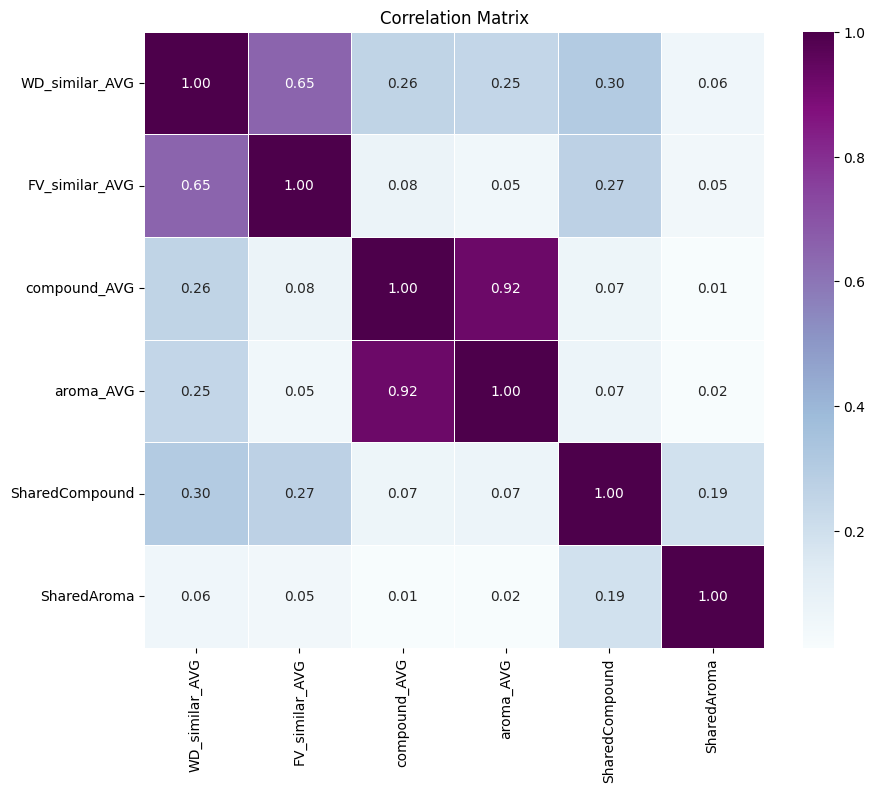

In [44]:
# ヒートマップをプロット
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="BuPu", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

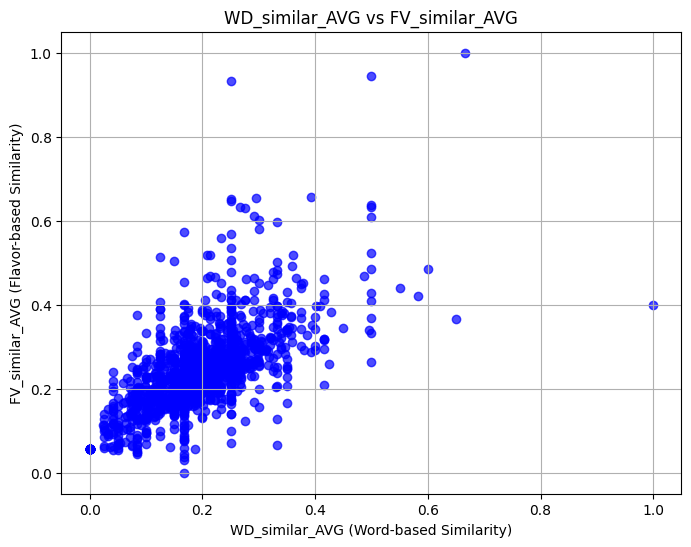

In [45]:
# 相関の可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_result["WD_similar_AVG"], df_result["FV_similar_AVG"], alpha=0.7, color="blue")
plt.title("WD_similar_AVG vs FV_similar_AVG")
plt.xlabel("WD_similar_AVG (Word-based Similarity)")
plt.ylabel("FV_similar_AVG (Flavor-based Similarity)")
plt.grid(True)
plt.show()

In [46]:
# 似てないやつ
# 差を計算して新しい列を作成
df_result["difference"] = abs(df_result["WD_similar_AVG"] - df_result["FV_similar_AVG"])

# 差が大きい順に並べ替え
sorted_df = df_result.sort_values(by="difference", ascending=False)

# 上位の行を確認
sorted_df.head()
df_result.to_csv("../data/analized_recipe.csv")

In [47]:
df_result[df_result["FV_similar_AVG"] > 0.9][["name", "WD_similar_AVG", "FV_similar_AVG", "compound_AVG"]].sort_values(by="FV_similar_AVG", ascending=True)

,name,WD_similar_AVG,FV_similar_AVG,compound_AVG
639,Cranberry Sauce,0.250000,0.931553,1.333333
383,Refreshing Jugo de Lulo: 'Little Orange' Juice...,0.500000,0.943347,2.000000
1070,Celery Cordial,0.666667,1.000000,8.333333


In [48]:
df_result[0.6 < df_result["FV_similar_AVG"]][["name", "WD_similar_AVG", "FV_similar_AVG"]].sort_values(by="FV_similar_AVG", ascending=True)

,name,WD_similar_AVG,FV_similar_AVG
1102,Modern Watergate Salad,0.300000,0.600255
436,Musk / Honey Dew Melon ( Galia / Kharbooza) #D...,0.500000,0.608881
440,Red and White Soursop Shakes,0.291667,0.611670
457,Sweet Potato Pie,0.275000,0.631127
382,Naranjilla (lulo) pulp · frozen · unsweetened,0.266667,0.632146
451,Acerola Juice [Recipe + Video] Jugo de Cereza ...,0.500000,0.633150
1136,Frozen Tajin Grapes,0.500000,0.635927
405,Grapefruit Tequila Sunrise,0.250000,0.646608
119,Bearclaw Drage Sweet Rolloat Mosering,0.250000,0.651286
1091,Caramel Apple Cheesecake Dip,0.294643,0.653844


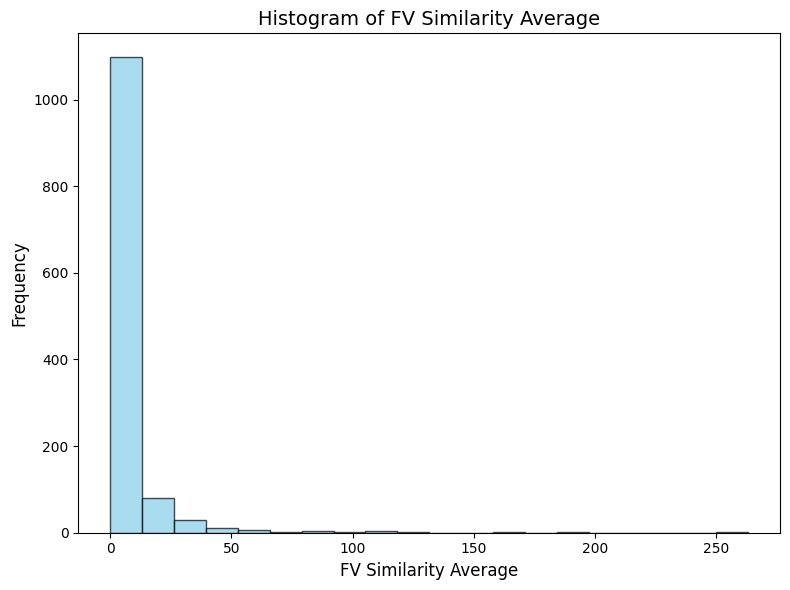

In [49]:
plt.figure(figsize=(8, 6))
plt.hist(df_result["compound_AVG"], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of FV Similarity Average", fontsize=14)
plt.xlabel("FV Similarity Average", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

## Word2Vec可視化

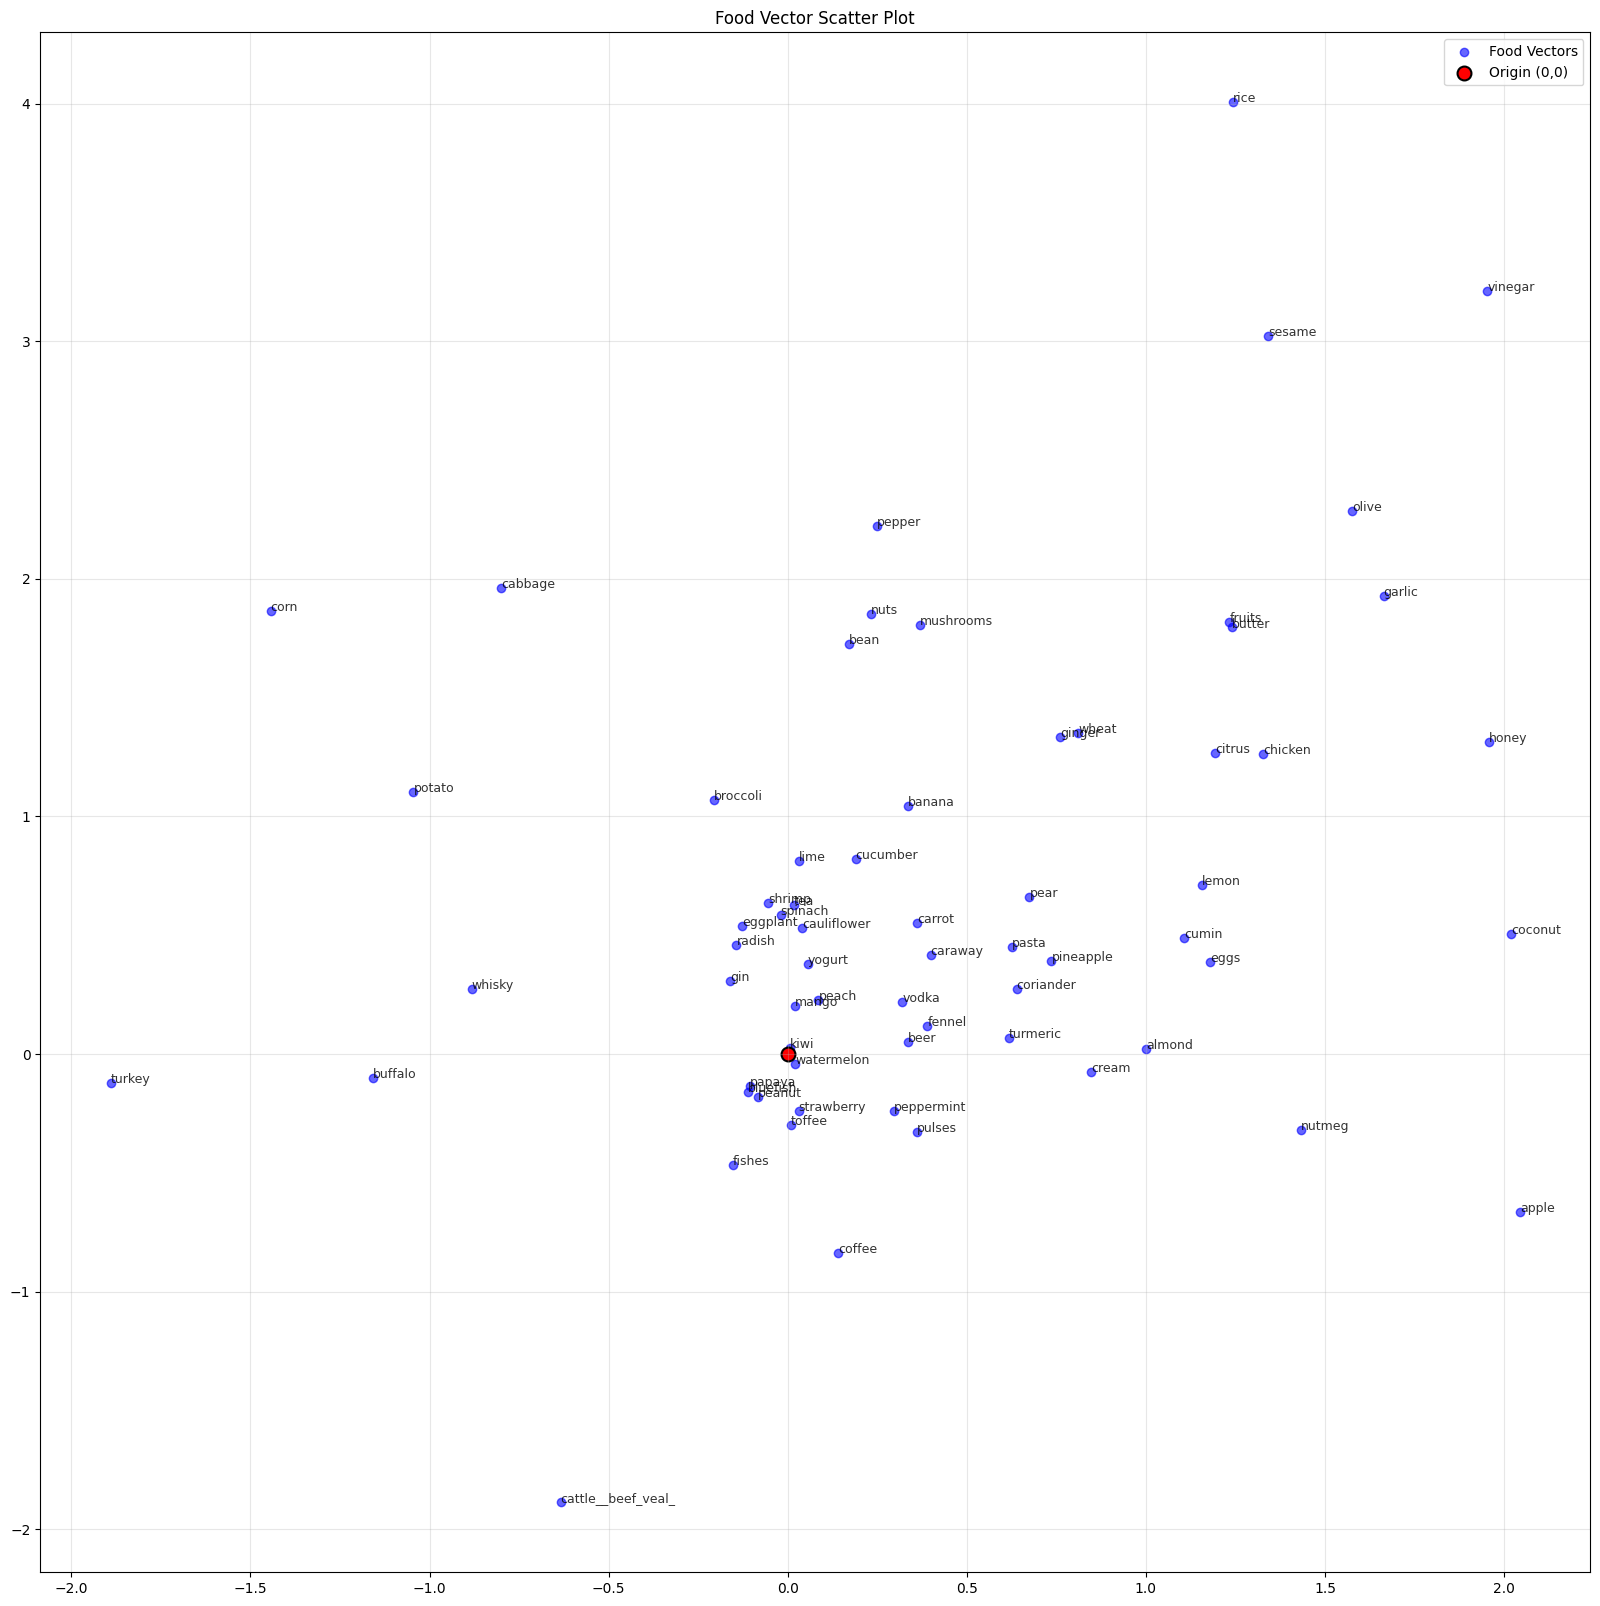

In [50]:
show_items = ['kiwi','garlic','pineapple','peanut','cattle__beef_veal_','chicken','cauliflower','broccoli',
'tea','pepper','papaya','caraway','watermelon','lime','lemon','coffee','coriander','cucumber',
'cumin','turmeric','fennel','strawberry','apple','mango','peppermint','nutmeg','olive','rice',
'almond','peach','pear','radish','sesame','eggplant','potato','spinach','corn','ginger','banana',
'carrot','beer','pasta','bluefish','buffalo','coconut','turkey','shrimp','wheat','eggs','yogurt',
'bean','vodka','whisky','gin','honey','vinegar','toffee','butter','cream','cabbage','mushrooms',
'citrus','fishes','pulses','nuts','fruits']

def find_food(tx):
    # クエリ実行と結果の取得
    return tx.run("MATCH (f:Food) RETURN f").data()

vectors = []
labels = []

with driver.session() as session:
    # クエリ結果をループ処理
    foods = session.execute_read(find_food)
    for i, record in enumerate(foods):
        vec = np.array(record["f"]["word_vector"])
        if record["f"]["id"] in show_items:
            vectors.append(vec)            
            labels.append((vec[:2], record["f"]["id"]))
            
vectors = np.array(vectors)
# 散布図をプロット
plt.figure(figsize=(20, 20))
plt.scatter(vectors[:, 0], vectors[:, 1], alpha=0.6, c="blue", label="Food Vectors")

# ラベルをプロット（10個に1つだけ）
for (x, y), label in labels:
    plt.text(x, y, label, fontsize=9, alpha=0.8)
    
plt.scatter(0, 0, c="red", s=100, label="Origin (0,0)", edgecolors="black", linewidth=1.5)
plt.title("Food Vector Scatter Plot")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### similarityの可視化

In [51]:
def project_similarity_graph(tx):
    tx.run("""
        CALL gds.graph.list() 
        YIELD graphName WITH graphName 
        WHERE graphName = 'kmeansGraph' 
        CALL gds.graph.drop('kmeansGraph') 
        YIELD graphName AS droppedGraph RETURN droppedGraph;
    """)
    tx.run("""
        CALL gds.graph.project(
            'kmeansGraph',
            {
                Food: {
                    properties: ['word_vector', 'flavor_vector']
                }
            },
            {
                CONTAINS: {
                    orientation: 'UNDIRECTED'
                }
            }
        );
     """)
    
def fetch_pagerank_and_edges():
    # Word2Vecのクラスタリングを取得
    word_query = """
        CALL gds.kmeans.stream('kmeansGraph', {
            nodeLabels: ['Food'],
            relationshipTypes: ['CONTAINS'],
            k: 100, // クラスタの数を指定
            maxIterations: 100, // 最大反復回数
            nodeProperty: 'word_vector' // クラスタリングに使用するプロパティ
        })
        YIELD nodeId, communityId, distanceFromCentroid, silhouette
        WITH gds.util.asNode(nodeId) AS node, communityId, distanceFromCentroid, silhouette
        RETURN node.id as id, node.name AS name, communityId, distanceFromCentroid, silhouette
        ORDER BY communityId, distanceFromCentroid;
    """
    
    # Flavorのクラスタリングを取得
    flavor_query = """
        CALL gds.kmeans.stream('kmeansGraph', {
            nodeLabels: ['Food'],
            relationshipTypes: ['CONTAINS'],
            k: 100, // クラスタの数を指定
            maxIterations: 100, // 最大反復回数
            nodeProperty: 'flavor_vector' // クラスタリングに使用するプロパティ
        })
        YIELD nodeId, communityId, distanceFromCentroid, silhouette
        WITH gds.util.asNode(nodeId) AS node, communityId, distanceFromCentroid, silhouette
        RETURN node.id as id, node.name AS name, node.display_name_ja as display_name_ja, communityId, distanceFromCentroid, silhouette
        ORDER BY communityId, distanceFromCentroid;
    """
    
    with driver.session() as session:
        session.write_transaction(project_similarity_graph)
        word_result = session.run(word_query)
        flavor_result = session.run(flavor_query)
        
        word_df = pd.DataFrame([dict(record) for record in word_result])
        flavor_df = pd.DataFrame([dict(record) for record in flavor_result])
        
    return word_df, flavor_df

# データ取得
word_df, flavor_df = fetch_pagerank_and_edges()


/var/folders/g4/fbyxhbrx6h3_4s4m15x3bly00000gn/T/ipykernel_57348/1744557776.py:57: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(project_similarity_graph)


In [52]:
word_df.tail(3)
word_df.to_csv('../tmp/word_df.csv')

In [53]:
flavor_df.tail(3)
flavor_df.to_csv('../tmp/flavor_df.csv')

In [54]:
# wordでもflavorでも同じコミュニティに属している組み合わせのidをリストに追加する
tt_list = []

# word_dfを1件づつ検査する
for i, row in word_df.iterrows():
    same_list = []
    food_id = row['id']
    community_id = row['communityId']
    same_community_ids = (flavor_df[flavor_df['communityId'] == community_id])['id'].values
    flavor_row = flavor_df[flavor_df['id'] == food_id]
    
    # 取得したcommunityIdと同じcommunityIdの行をflavor_dfから抽出する
    community_rows = flavor_df[flavor_df['communityId'] == flavor_row["communityId"].values[0]]
    
    for j, f_row in community_rows.iterrows():
        if f_row['id'] in same_community_ids:
            same_list.append((f"{f_row['id']}: {f_row['display_name_ja']}"))
            
    if same_list is not None and len(same_list) > 0:
        tt_list.append(same_list)

matched = pd.DataFrame(tt_list)
matched.transpose()
matched.transpose().to_csv('../tmp/matched.csv')